In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib as jl
from functions import *
#Reload functions module to get latest changes
import importlib
importlib.reload(__import__('functions'))
import tqdm as tq

Fundamental electric fields:
$$
E_j(z,t) = \cfrac{1}{2} [A_j(z)e^{i(k_jz-\omega_j t)}+A_j^*(z)e^{-i(k_jz-\omega_j t)}]
$$
Wavevectors: 
$$
k_j=\cfrac{n_j(\omega_j,T)\omega_j}{c} \qquad j\in \{\omega,2\omega \}
$$
Sellmeier refractive index:
$$
n_z^2(\lambda, 25^\circ\text{C}) = A + \frac{B}{1 - \frac{C}{\lambda^2}} + \frac{D}{1 - \frac{E}{\lambda^2}} - F \lambda^2.
$$
Polynomial expansion refractive index:
$$
\begin{aligned}
\Delta n_z(\lambda, T) = \quad &(T - 25) \left( a_{10} + \frac{a_{11}}{\lambda} + \frac{a_{12}}{\lambda^2} + \frac{a_{13}}{\lambda^3} \right) \\
&+ (T - 25)^2 \left( a_{20} + \frac{a_{21}}{\lambda} + \frac{a_{22}}{\lambda^2} + \frac{a_{23}}{\lambda^3} \right)
\end{aligned}
$$
Full:
$$
n_z(\lambda, T) = n_z(\lambda, 25^\circ\text{C}) + \Delta n_z (\lambda,T)
$$
Phase mismatch:
$$
\Delta k = k_{2\omega} - 2k_\omega
$$
With compensation from reciprocal lattice vector of pooled structure:
$$
\Delta k_Q = \Delta k - \cfrac{2\pi}{\Lambda(T)}
$$
Modelling $\Lambda(T)$
$$
\Lambda(T) = \Lambda_0[1+\alpha_z (T-T_0)]
$$
Effective non-linear coefficient:
$$
d_{eff} = \cfrac{2}{\pi}d_{33}
$$
Assuming an undepleted pump (Aω constant), the second-58
harmonic field at the output of a periodically poled crystal of59
length L with ideal edges (∆l,r = 0):
$$
A_{2\omega} = L e^{iL\Delta k_Q /2}\mathrm{sinc} \left(  \cfrac{L\Delta k_Q}{2} \right)
$$

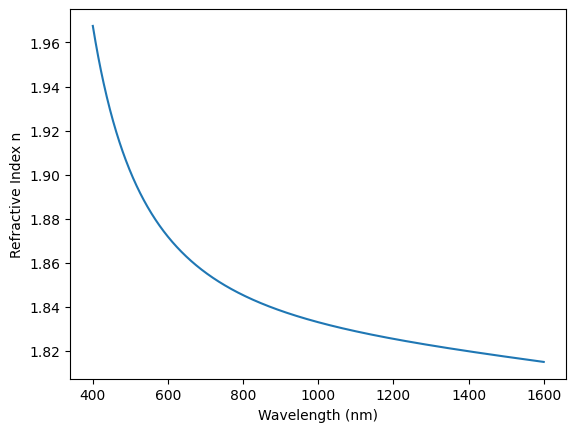

In [48]:
#Plotting refractive index as a function of wavelength
#Parameters for the Sellmeier
A = 2.12725
B = 1.18431
C = 5.14852e-2
D = 0.6603
E = 100.00507
F = 9.68956e-3
#These experimental parameters are taken from "K. Fradkin, A. Arie, A. Skliar, and G. Rosenman"
wavelengths = np.linspace(400, 1600, 1000) #Wavelengths in nm
temperature = 300  # Temperature in Kelvin
a1_list = np.array([9.9587, 9.9228, -8.9603, 4.1010])*1e-6  # Experimental values taken from S. Emanueli and A. Arie
a2_list = np.array([-1.1882 ,10.459, -9.8136, 3.1481])*1e-8  # Experimental values taken from S. Emanueli and A. Arie
n_values = refractive_index_total(temperature, A, B, C, D, E, F, a1_list, a2_list, wavelengths)
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Refractive Index n")
ax.plot(wavelengths, n_values)


In [49]:
temperature = np.linspace(200, 400, 200)  # Temperature in Kelvin
#Frequency for 1550 nm
wavelengths = np.array([1550, 775])  # Wavelengths in nm
c = 299792458
frequencies = c / (wavelengths * 1e-9)  # Frequencies in Hz
omegas = 2 * np.pi * frequencies  # Angular frequencies in rad/s
n_value_list = []
for i in tq.tqdm(range(len(wavelengths))):
    n_values = refractive_index_total(temperature, A, B, C, D, E, F, a1_list, a2_list, np.array([wavelengths[i]]))
    n_value_list.append(n_values)
n_value_array = np.array(n_value_list)
Lambda_0 = 24.701e-6  # Poling period of the crystal in meters
T_ref = 25 + 273.15  # Reference temperature in Kelvin
a_z = 8.7e-6 #C^-1, Linear thermal expansion coefficient for KTP. Taken from Shai Emanueli and Ady Arie
QPM = quasi_phase_mismatch(n_value_array[1,:], omegas[1], n_value_array[0,:], omegas[0], Lambda_0, temperature, T_ref, a_z)
L = 405*Lambda_0
SHG_output = second_harmonic_output(QPM, L)  # Crystal length in meters, Input intensity in W/m^2

100%|██████████| 2/2 [00:00<00:00, 1698.79it/s]


For perfect edges Δr and Δl are 0 and assuming undepleted pump such that A_omega is constant


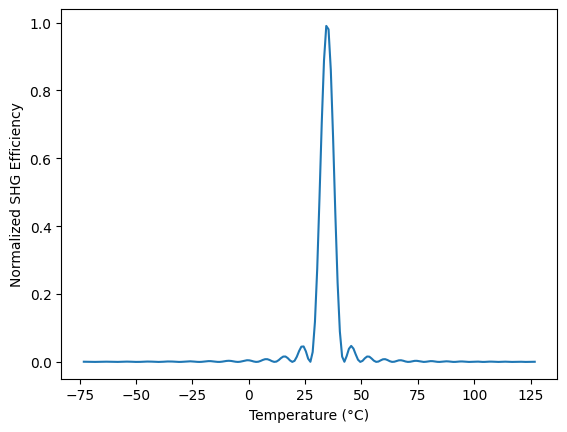

In [50]:
fig, ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("SHG at output (a.u.)")
ax.plot(temperature - 273.15, (SHG_output/L)**2)
ax.set_ylabel("Normalized SHG Efficiency")
# ax.set_ylim(-100, 100) # Removed to allow autoscaling
print("For perfect edges Δr and Δl are 0 and assuming undepleted pump such that A_omega is constant")
plt.show()

## Double-pass non linear interaction

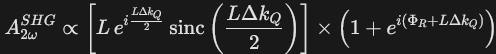

100%|██████████| 3/3 [00:00<00:00, 1475.14it/s]


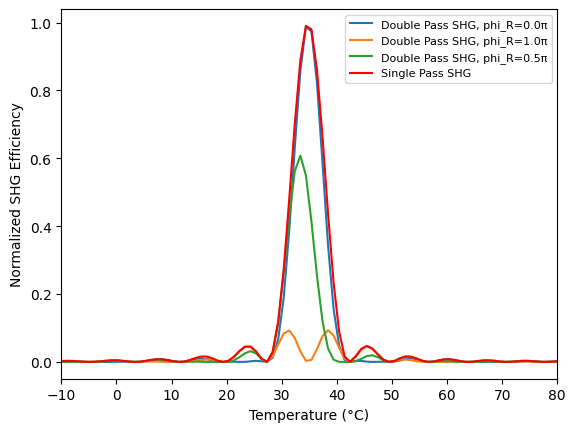

In [51]:
phi_R = np.pi*np.array([0,1,1/2])
double_pass_val = []
for i in tq.tqdm(range(len(phi_R))):
    double_pass_SHG_output = double_pass_SHG(QPM, L, phi_R[i])
    double_pass_val.append(double_pass_SHG_output)
fig, ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("SHG at output (a.u.)")
for i in range(len(phi_R)):
    double_pass_SHG_output = double_pass_val[i]
    ax.plot(temperature - 273.15, (double_pass_SHG_output/L)**2 /4, label=f'Double Pass SHG, phi_R={phi_R[i]/np.pi}π')
ax.plot(temperature - 273.15, (SHG_output/L)**2, color='r', label='Single Pass SHG')
ax.set_ylabel("Normalized SHG Efficiency")
ax.set_xlim(-10,80)
ax.legend(prop={'size':8})

## Inside optical cavity
Mirror with has reflectivity and transmitivity of $\rho$ and $\tau$. Mirror is a distance $D$ from crystal. We now have 4 intracavity electric fields.
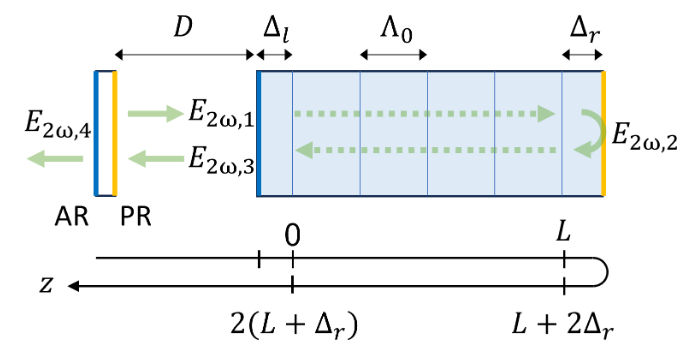


$$
E_{2\omega,1} = \rho\, E_{2\omega,3}
$$

$$
E_{2\omega,2} = e^{-i k_{2\omega} D}
\left(
E_{2\omega,1} + E^{(1)}_{2\omega} e^{-i \Delta k(T)\, \Delta r}
\right)
$$

$$
E_{2\omega,3} = e^{-i k_{2\omega} D}
\left(
E_{2\omega,2} + E^{(2)}_{2\omega} e^{-i \Delta k(T)\, \Delta l}
\right)
$$

$$
E_{2\omega,4} = i\, \tau\, E_{2\omega,3}.
$$


In [ ]:
tau = 0.5 #Transmission coefficient of the output coupler
rho = 0.5 #Reflection coefficient of the output coupler
Delta_r = 1e-6 #Error in the right edge of the crystal
Delta_l = 1e-6 #Error in the left edge of the crystal
D = 1e-3 #Distance from the crystal to the output coupler
exiting_field = final_cavity_field(tau, rho, QPM, L, Delta_r, Delta_l, D, n_value_array[0,:], omegas[0], n_value_array[1,:], omegas[1])


Text(0, 0.5, 'Normalized SHG Efficiency')

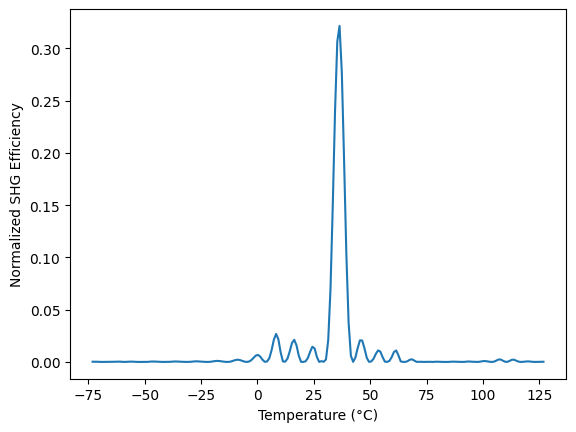

In [ ]:
fig,ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("SHG at output (a.u.)")
ax.plot(temperature - 273.15, np.abs(exiting_field)**2, label='Cavity SHG Output')
ax.set_ylabel("Normalized SHG Efficiency")